# <span style="color:#cee879">**Trabajo Final**</span>


### **<span style="color:#cee879">Proyecto machine learning**

Entrenamiento de un modelo de machine learning capaz de predecir con precisión los salarios laborales en función de una serie de características sociodemográficas

In [1]:
import pandas as pd  # Para manipulación de datos
import numpy as np  # Para operaciones numéricas
import seaborn as sns  # Para visualizaciones
import matplotlib.pyplot as plt  #* Para visualizaciones
from sklearn.linear_model import Lasso  #* Modelo de regresión Lasso
from sklearn.model_selection import GridSearchCV  #* Para búsqueda de hiperparámetros
from sklearn.ensemble import RandomForestRegressor  #* Modelo de Random Forest
from sklearn.metrics import make_scorer  #* Para crear métricas personalizadas
from sklearn.metrics import mean_absolute_percentage_error  #* Métrica MAPE
from sklearn.model_selection import train_test_split  #* Para dividir los datos en entrenamiento y prueba
from sklearn.model_selection import cross_val_score  #* Para validación cruzada
import warnings  # Para suprimir advertencias
warnings.filterwarnings("ignore")

In [2]:
# Leer el archivo final de R
df = pd.read_excel('../data/final/data_piura_final.xlsx')

# Crear age al cuadrado apra capturar el estado generacional
df['age_squared'] = df['age'] ** 2

# Seleccionar columnas relevantes para el nuevo dataframe
selected_columns = [
    'ln_ing_lab' , 'lngasfam', 'nucleo', 'age_squared', 'sch',
    'niv_edu_g', 'jefe', 'pobreza', 'urban', 'ramactsec', 'male'
]
piura_df = df[selected_columns]

# Guardar el nuevo dataframe en un archivo CSV
piura_df.to_csv('../data/final/piura_df.csv', index=False)

# Transformar variables categóricas en dummies (usando piura_df, no df)
categorical_columns = ['niv_edu_g', 'pobreza', 'jefe', 'urban', 'ramactsec', 'male']
piura_df = pd.get_dummies(piura_df, columns=categorical_columns, drop_first=True)

# Verificar el resultado
piura_df.head()


,ln_ing_lab,lngasfam,nucleo,age_squared,sch,niv_edu_g_Secundaria completa,niv_edu_g_Secundaria incompleta,niv_edu_g_Superior completa,niv_edu_g_Superior incompleta,pobreza_pobre extremo,pobreza_pobre no extremo,jefe_Yes,urban_urbano,ramactsec_Sector Secundario,ramactsec_Sector Terciario,male_Mujer
0,6.448758,7.364911,1,625,14,False,False,False,True,False,False,True,True,False,True,True
1,5.714008,7.364911,0,841,16,False,False,True,False,False,False,True,True,False,True,True
2,7.098513,7.726000,1,2304,10,False,True,False,False,False,False,True,True,False,False,True
3,6.750126,7.834666,1,1444,14,False,False,True,False,False,False,True,True,False,True,False
4,7.102293,7.834666,1,1849,14,False,False,True,False,False,False,False,True,False,True,True


### **<span style="color:#8cd19d">Despliegue de los datos para entrenamiento y testeo**

In [3]:
# Nuevo dataframe para el modelado
df_model = piura_df.copy()

# Separar en X (características) e y (target)
X = df_model.drop('ln_ing_lab', axis=1)
y = df_model['ln_ing_lab']

# Guardo mi df_model
df_model.to_csv("../data/final/df_model.csv", index=False)

#* Train y Test:
from sklearn.model_selection import train_test_split

#* División 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### **<span style="color:#8cd19d">Estimación de un modelo Lasso para la selección de variables**

In [4]:
model = Lasso(alpha = 0.5, random_state=42)
# alpha: El hiperparámetro alpha controla la fuerza de la regularización L1 (Lasso). 

model.fit(X_train, y_train)

test_pred = model.predict(X_test)
#test_pred = test_pred.reshape(-1, 1)
train_pred = model.predict(X_train)
#train_pred = train_pred.reshape(-1, 1)

In [13]:
from sklearn import metrics
# Función print_evaluate(true, predicted): imprime las métricas de evaluación del modelo.
def print_evaluate(true, predicted):  

    '''
    La función `print_evaluate` evalúa el rendimiento de un modelo de predicción 
    comparando los valores verdaderos (`true`) con los valores predichos (`predicted`). 
    Realiza los siguientes cálculos y muestra los resultados en la consola:

    1. `mape`: Calcula el Error Porcentual Absoluto Medio (MAPE), que mide la precisión del modelo como un porcentaje.
    2. `mpe`: Calcula el Error Porcentual Medio (MPE), que también mide la precisión pero puede tener valores negativos 
    y positivos indicando la dirección del error.
    3. `r2_square`: Calcula el coeficiente de determinación R², que indica la proporción de la varianza en la variable 
    dependiente que es predecible a partir de las variables independientes.
    4. Calcula el porcentaje de observaciones que se encuentran dentro del ±20% de error relativo (MAPE).

    Los resultados de estos cálculos se imprimen en la consola con etiquetas descriptivas para facilitar la interpretación.
    '''
    
    mape = np.mean(np.abs((true - predicted) / true)) * 100  # Error porcentual absoluto medio (MAPE)
    mpe = np.mean((true - predicted) / true) * 100  # Error porcentual medio (MPE)
    r2_square = metrics.r2_score(true, predicted)  # Coeficiente de determinación R^2
    
    # Calcular el porcentaje de observaciones dentro del ±20% de MAPE
    ape = np.abs((true - predicted) / true) * 100
    within_20_percent = np.sum(ape <= 20) / len(true) * 100
    
    print('MAPE:', mape)
    print('MPE:', mpe)
    print('R2 Square:', r2_square)
    print('% Observaciones en ±20% de MAPE:', within_20_percent)

In [6]:
# Función personalizada para MAPE
def mape(true, predicted):
    """
    Calcula el Error Porcentual Absoluto Medio (MAPE).
    true: Valores reales
    predicted: Valores predichos
    """
    return np.mean(np.abs((true - predicted) / true)) * 100

# Crear un scorer para GridSearchCV (MAPE negativo porque GridSearchCV maximiza las métricas)
mape_scorer = make_scorer(mape, greater_is_better=False)

In [7]:
#* Configurar la búsqueda de hiperparámetros con GridSearchCV

# Rango de valores para el hiperparámetro alpha
param_grid = {
    'alpha': np.logspace(-4, 0, 50)  # 50 valores entre 0.0001 y 1 en escala logarítmica
}

# Configurar GridSearchCV
grid_search_lasso = GridSearchCV(
    estimator=Lasso(random_state=42),
    param_grid=param_grid,
    scoring=mape_scorer,  # Usar la métrica MAPE como scorer
    cv=5,                 # Validación cruzada con 5 particiones
    verbose=1             # Mostrar progreso del GridSearch
)

# Ajustar el modelo Lasso con GridSearchCV
grid_search_lasso.fit(X_train, y_train)

# Obtener el mejor valor de alpha encontrado
best_alpha = grid_search_lasso.best_params_['alpha']
print(f"Mejor valor de alpha encontrado: {best_alpha}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejor valor de alpha encontrado: 0.0001


In [14]:
# Entrenar el modelo Lasso con el mejor alpha
best_lasso = Lasso(alpha=best_alpha, random_state=42)
best_lasso.fit(X_train, y_train)

# Predicciones en el conjunto de entrenamiento
train_pred_lasso = best_lasso.predict(X_train)

# Predicciones en el conjunto de prueba
test_pred_lasso = best_lasso.predict(X_test)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred_lasso)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred_lasso)

Test set evaluation:
_____________________________________
MAPE: 8.85524809854673
MPE: -1.4579269078785293
R2 Square: 0.2940290226142088
% Observaciones en ±20% de MAPE: 90.93886462882097
Train set evaluation:
_____________________________________
MAPE: 9.290251876025637
MPE: -1.3783886410797839
R2 Square: 0.2617430687575054
% Observaciones en ±20% de MAPE: 90.25761124121779


En Lasso, los coeficientes cercanos a cero indican que la variable fue menos importante. Podemos visualizar los coeficientes:

In [15]:
# Obtener los coeficientes de las variables
coefficients = best_lasso.coef_ 

feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': coefficients
})

# Ordenar por la importancia de los coeficientes
feature_importance = feature_importance.sort_values(by='Coeficiente', ascending=False)
print("Importancia de las Variables:")
print(feature_importance)

Importancia de las Variables:
                           Variable  Coeficiente
12      ramactsec_Sector Secundario     0.240217
0                          lngasfam     0.231148
10                         jefe_Yes     0.187198
13       ramactsec_Sector Terciario     0.139227
1                            nucleo     0.114496
11                     urban_urbano     0.082040
6       niv_edu_g_Superior completa     0.079810
3                               sch     0.037563
2                       age_squared    -0.000069
4     niv_edu_g_Secundaria completa    -0.110454
5   niv_edu_g_Secundaria incompleta    -0.150455
7     niv_edu_g_Superior incompleta    -0.179959
9          pobreza_pobre no extremo    -0.198864
14                       male_Mujer    -0.331337
8             pobreza_pobre extremo    -0.523582


### **<span style="color:#8cd19d">Estimación de un modelo RandomForest**

Después de seleccionar las variables con Lasso, el siguiente paso es entrenar
un modelo Random Forest utilizando las variables seleccionadas y con los mejores parámetros.

<span style="color:#cee879">**Random Forest Regressor** 

Random Forest es un modelo de ensamble basado en árboles de decisión que se utiliza para tareas de regresión.
Combina múltiples árboles para mejorar la precisión y manejar relaciones no lineales.

In [16]:
# Filtrar las variables seleccionadas (coeficientes distintos de cero)
selected_features = feature_importance[feature_importance['Coeficiente'] != 0]['Variable'].tolist()

# Crear un nuevo conjunto de datos con las variables seleccionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Variables seleccionadas: {selected_features}")


Variables seleccionadas: ['ramactsec_Sector Secundario', 'lngasfam', 'jefe_Yes', 'ramactsec_Sector Terciario', 'nucleo', 'urban_urbano', 'niv_edu_g_Superior completa', 'sch', 'age_squared', 'niv_edu_g_Secundaria completa', 'niv_edu_g_Secundaria incompleta', 'niv_edu_g_Superior incompleta', 'pobreza_pobre no extremo', 'male_Mujer', 'pobreza_pobre extremo']


<span style="color:#cee879">**Búsqueda de hiperparámetros para n_estimators con GridSearchCV** 

In [17]:
# Rango de hiperparámetros para RandomForest
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [5, 10, 20, None],       # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],      # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]         # Mínimo número de muestras en una hoja
}

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring=mape_scorer,  # Métrica MAPE como scorer
    cv=5,                 # Validación cruzada con 5 particiones
    verbose=1,            # Mostrar progreso de la búsqueda
    n_jobs=-1             # Utilizar todos los núcleos disponibles
)
# Ajustar el modelo RandomForest con GridSearchCV
grid_search_rf.fit(X_train_selected, y_train)

# Obtener los mejores parámetros encontrados
best_params_rf = grid_search_rf.best_params_
print("Mejores parámetros encontrados:")
print(best_params_rf)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Mejores parámetros encontrados:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


In [18]:
# Ajustar el modelo RandomForest con GridSearchCV
grid_search_rf.fit(X_train_selected, y_train)

# Obtener los mejores parámetros encontrados
best_params_rf = grid_search_rf.best_params_
print("Mejores parámetros encontrados:")
print(best_params_rf)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Mejores parámetros encontrados:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


In [19]:
# Entrenar el modelo RandomForest con los mejores parámetros
best_rf_model = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    random_state=42
)

# Entrenar el modelo con las variables seleccionadas
best_rf_model.fit(X_train_selected, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=300, random_state=42)

In [20]:
# Predicciones en el conjunto de entrenamiento
train_pred_rf = best_rf_model.predict(X_train_selected)

# Predicciones en el conjunto de prueba
test_pred_rf = best_rf_model.predict(X_test_selected)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred_rf)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred_rf)

Test set evaluation:
_____________________________________
MAPE: 8.734304974689783
MPE: -1.0428106526389103
R2 Square: 0.28665206143697997
% Observaciones en ±20% de MAPE: 91.5938864628821
Train set evaluation:
_____________________________________
MAPE: 6.6681890719836305
MPE: -0.9250401645825872
R2 Square: 0.6053977172790732
% Observaciones en ±20% de MAPE: 95.1288056206089


 <span style="color:#cee879">**MAPE (Mean Absolute Percentage Error):**

Las predicciones están un 8.73% desviadas de los valores reales, y el modelo ajusta mejor los datos de entrenamiento 6.67%.

 <span style="color:#cee879">**MPE (Mean Percentage Error):**

El modelo tiende a subestimar ligeramente las predicciones -1.04%, incluso para el conjunto de entrenamiento con un MPE de -0.93%.

 <span style="color:#cee879">**R²:**

En el conjunto de entrenamiento, el modelo explica el 60.5% de la variabilidad, lo que indica un buen ajuste en los datos de entrenamiento, pero explica el 28.7% de la variabilidad en los datos de prueba

 <span style="color:#cee879">**% Observaciones en ±20% de MAPE:**

Más del 91.59% de las observaciones tienen un error relativo menor al 20%, lo que indica que el modelo realiza predicciones precisas en la mayoría de los casos en el conjunto de prueba. En el conjunto de entrenamiento, este porcentaje sube a 95.13%

### **<span style="color:#8cd19d">Visualización de la distribución de los errores**

Visualización de la distribución de los errores en el grupo de training y
testing a través de histograma y densidad.

In [21]:
# Errores residuales
train_errors = y_train - train_pred_rf
test_errors = y_test - test_pred_rf

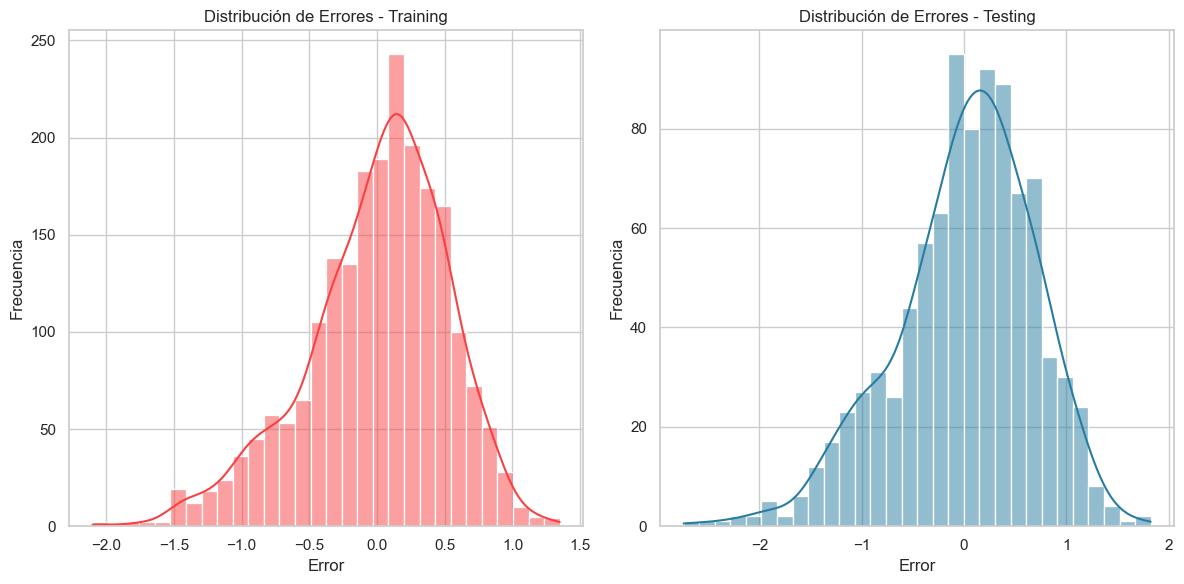

In [24]:
# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Crear histogramas para training y testing
plt.figure(figsize=(12, 6))

# Histograma de errores en training
plt.subplot(1, 2, 1)
sns.histplot(train_errors, kde=True, color="#f94144", bins=30)
plt.title("Distribución de Errores - Training")
plt.xlabel("Error")
plt.ylabel("Frecuencia")

# Histograma de errores en testing
plt.subplot(1, 2, 2)
sns.histplot(test_errors, kde=True, color="#277da1", bins=30)
plt.title("Distribución de Errores - Testing")
plt.xlabel("Error")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

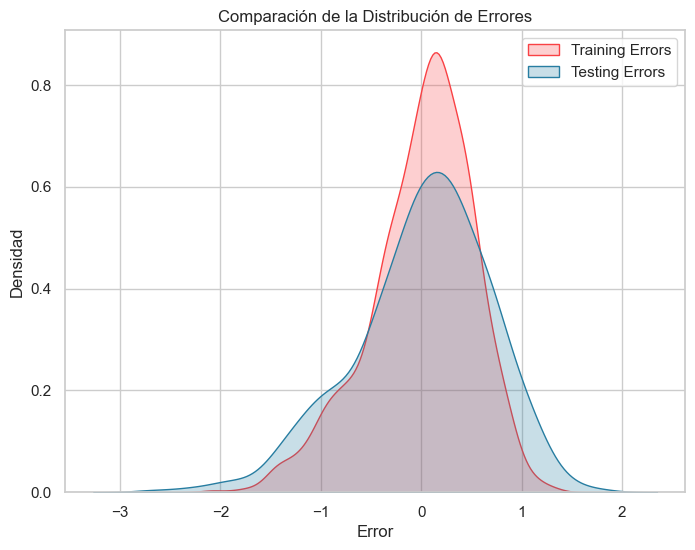

In [25]:
# Crear gráfico KDE para comparar los errores
plt.figure(figsize=(8, 6))

sns.kdeplot(train_errors, label="Training Errors", color="#f94144", fill=True)
sns.kdeplot(test_errors, label="Testing Errors", color="#277da1", fill=True)

plt.title("Comparación de la Distribución de Errores")
plt.xlabel("Error")
plt.ylabel("Densidad")
plt.legend()
plt.show()

El modelo generaliza bien, pero muestra un ajuste ligeramente mejor en los datos de entrenamiento en comparación con los datos de prueba, como se refleja en la mayor dispersión de la curva azul. Esto puede ser esperado en la mayoría de los modelos, y no indica sobreajuste severo.

### **<span style="color:#8cd19d">Validación cruzada de 5 pliegues MAPE con cross_val_score**

<span style="color:#cee879">**¿Cómo estamos seguros de que nuestros resultados son concisos en diferentes muestras?**

La validación cruzada consiste en dividir los datos en múltiples subconjuntos, entrenar el modelo en algunos de estos subconjuntos y evaluar su rendimiento en los subconjuntos restantes. Esto se repite varias veces para asegurar que cada punto de datos aparezca en el conjunto de entrenamiento y en el conjunto de validación.

In [26]:
# Crear un scorer personalizado para MAPE (negativo para que GridSearchCV sea compatible)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [27]:
# Realizar una validación cruzada con los mejores hiperparámetros utilizando MAPE
cv_scores = cross_val_score(best_rf_model, X_train_selected, y_train, cv=5, scoring=mape_scorer)

# Convertir los valores negativos a positivos
cv_mape_scores = -cv_scores

# Calcular promedio y desviación estándar del MAPE
mean_cv_mape = np.mean(cv_mape_scores)
std_cv_mape = np.std(cv_mape_scores)

# Mostrar resultados
print(f"CV MAPE Scores: {cv_mape_scores}")
print(f"Mean CV MAPE: {mean_cv_mape}")
print(f"Standard Deviation of CV MAPE: {std_cv_mape}")

CV MAPE Scores: [0.08981491 0.09082478 0.08879224 0.09251604 0.08645511]
Mean CV MAPE: 0.08968061665309386
Standard Deviation of CV MAPE: 0.0020277988253995104


 <span style="color:#cee879">**MAPE Scores por pliegue:**

El rango es estrecho, lo que indica que el modelo tiene un desempeño consistente en diferentes subconjuntos de los datos.

 <span style="color:#cee879">**(Mean CV MAPE):**

Promedio del MAPE es menor (9% aprox). Esto indica que las predicciones del modelo tienen un error absoluto relativo bajo.

<span style="color:#cee879">Dado el bajo MAPE promedio y la consistencia entre pliegues, el modelo Random Forest es robusto.